## Part 1: Import statements

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from seaborn import heatmap
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from collections import Counter

import tensorflow
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras
from tensorflow.keras import Model, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding,MaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution1D as Conv1D, InputLayer, concatenate, LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from tensorflow.keras.utils import set_random_seed
from tensorflow.data import Dataset


from gensim.models import Word2Vec
import os
import zipfile

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
set_random_seed(1)

## Part 2: Importing cleaned data

In [3]:
data = pd.read_csv("Data/processed_data.csv", index_col=0)
data = data.dropna()
data

,tweet,class
0,woman shouldnt complain cleaning house man alw...,2
1,boy dats coldtyga dwn bad cuffin dat hoe place,1
2,dawg ever fuck bitch stato cry confused shit,1
3,look like tranny,1
4,shit hear might true might faker bitch told ya,1
...,...,...
25291,yous muthafin lie right tl trash mine bible sc...,1
25292,youve gone broke wrong heababy drove redneck c...,2
25294,young buck wan na eat dat nigguh like aint fuc...,1
25295,youu got wild bitches tellin lies,1


In [4]:
number_tweets = len(data["tweet"])
print(f"Number of sentences: {number_tweets}")

Number of sentences: 23865


## Part 3: Splitting Data

In [5]:

#splitting the data into train, validation, test
X, X_test, y, y_test = train_test_split(data['tweet'], data['class'],  test_size=0.2, random_state=42)#previously 0.2

In [6]:
#splitting the data into train and validation
X_train, X_cv, y_train, y_cv = train_test_split(X,y,test_size = 0.25,train_size =0.75, random_state=42)#previously 0.25, 0.75

In [7]:
X_train.sample(5)

13051       man bitch dont call back job cuhh uma snapping
14519    realised library books overdue anyones looking...
10937    like kids beyond scared straight acting like h...
12297                                         winter bitch
18320             somewhere ghetto nigger getting shot bbq
Name: tweet, dtype: object

## Oversampling

In [8]:

def oversample(X_train, y_train):
    print("Before Oversampling: {}".format(Counter(y_train)))

    # # define oversampling strategy
    oversample = RandomOverSampler(sampling_strategy='all')

    # # fit and apply the transform
    X_train_over, y_train_over = oversample.fit_resample(X_train, y_train)
    print("After Oversampling: {}".format(Counter(y_train_over)))
    
    return X_train_over, y_train_over

In [9]:
#X_train_tk_over, y_train_over = oversample(X_train_tk, y_train)
X_train_over, y_train_over = oversample(np.array(X_train).reshape(-1,1), y_train)

X_train_over = pd.Series(X_train_over.reshape(len(X_train_over)))


Before Oversampling: Counter({1: 11062, 2: 2437, 0: 820})
After Oversampling: Counter({1: 11062, 2: 11062, 0: 11062})


## Tokenization

In [10]:
tokenizer = Tokenizer()

#fitting tokenizer on training set
tokenizer.fit_on_texts(X_train_over)

#encoding training data
encoded_train = tokenizer.texts_to_sequences(X_train_over)
encoded_cv = tokenizer.texts_to_sequences(X_cv)
encoded_test = tokenizer.texts_to_sequences(X_test)

#padding sequences using the maximum sequence of the training set
max_length = max([len(sentence.split()) for sentence in X_train_over])


X_train_tk = pad_sequences(encoded_train,maxlen = max_length, padding = "post" )
X_cv_tk =pad_sequences(encoded_cv,maxlen = max_length, padding = "post" )
X_test_tk =pad_sequences(encoded_test,maxlen = max_length, padding = "post" )

In [11]:
vocab_size = len(tokenizer.word_index)+1
vocab_size

15992

In [12]:
#  encoding target variable
y_train_encoded = to_categorical(y_train_over,3)
y_cv_encoded = to_categorical(y_cv,3)
y_test_encoded = to_categorical(y_test,3)


In [13]:
y_train_encoded

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

## Print Model statistics

In [14]:
def printModelStats(y_preds, y_test):
    print(classification_report(y_test, y_preds, target_names = ['Hate', 'Offensive', 'Neither']))
   
    cm = confusion_matrix(y_test, y_preds)
    print("The confusion matrix:")
    print(cm)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 
    sns.heatmap((cm_percent), annot = True, cmap = "Blues").set(title ="Confusion Matrix Expressed in %")

In [15]:
def printResults(history):
    results = pd.DataFrame(history.history)
    return results

In [16]:
def plotLossCurves(history):
    results = pd.DataFrame(history.history)
    
    plt.figure(figsize = (10,5))
    plt.plot(results.index, results.loss)
    plt.plot(results.index, results.val_loss)
    plt.title("CNN model")
    plt.xlabel("Epochs")
    plt.ylabel("Categorical Crossentropy Loss")
    plt.legend(["Training Loss", "Validation Loss"])
    plt.show()

In [17]:
def plotAccuracyCurves(history):
    results = pd.DataFrame(history.history)
    
    plt.figure(figsize = (10,5))
    plt.plot(results.index, results.accuracy)
    plt.plot(results.index, results.val_accuracy)
    plt.title("LSTM model")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(["Training Accuracy", "Validation Accuracy"])
    plt.show()

## CNN with custom word embedding

Simple 1D Convolutional neural network to capture the sequence of words 
- inspired by: https://machinelearningmastery.com/develop-word-embedding-model-predicting-movie-review-sentiment/

In [34]:
# #Model 1


from keras.layers import SpatialDropout1D


def createLSTM1(units=100, output_dimension=100):
    input = Input(shape=(max_length,), dtype="int32")
    embedding_layer = Embedding(input_dim=vocab_size, output_dim=output_dimension, input_length=max_length)(input)
    dropout = SpatialDropout1D(0.2)(embedding_layer)
    layer = LSTM(units)(dropout)
    output = Dense(3, activation = "softmax") (layer)

    model1 = Model(inputs=input, outputs=output)
    optimizer = tensorflow.optimizers.Adam(lr=0.001)
    model1.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    model1.summary()

    return model1


early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=3, verbose=1)
callbacks_list = [early_stopping]

In [35]:
model1 = createLSTM1()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 127)]             0         
                                                                 
 embedding_6 (Embedding)     (None, 127, 100)          1599200   
                                                                 
 spatial_dropout1d_2 (Spati  (None, 127, 100)          0         
 alDropout1D)                                                    
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dense_5 (Dense)             (None, 3)                 303       
                                                                 
Total params: 1679903 (6.41 MB)
Trainable params: 1679903 (6.41 MB)
Non-trainable params: 0 (0.00 Byte)
_____________________

In [36]:

history = model1.fit(X_train_tk, y_train_encoded, epochs =10, batch_size=64, validation_data = (X_cv_tk, y_cv_encoded)) #, callbacks=callbacks_list

#vs batch size 64

Epoch 1/10
112/519 [=====>........................] - ETA: 1:20 - loss: 1.0996 - accuracy: 0.3393

KeyboardInterrupt: 

evaluation

In [23]:
loss,acc = model1.evaluate(X_cv_tk, y_cv_encoded)


150/150 [==============================] - 1s 5ms/step - loss: 0.9346 - accuracy: 0.8360


In [24]:
printResults(history)

,loss,accuracy,val_loss,val_accuracy
0,1.055378,0.438468,0.855153,0.210350
1,0.942905,0.498945,0.889636,0.645087
2,0.910618,0.551196,0.845342,0.724911
3,0.890415,0.583288,0.829366,0.772051
4,0.877418,0.604984,0.829484,0.783365
5,0.737719,0.728621,0.840614,0.794259
6,0.676814,0.778159,0.847937,0.820029
7,0.607589,0.792623,0.903571,0.823382
8,0.556201,0.805129,0.889710,0.834695
9,0.540130,0.809558,0.934629,0.835952


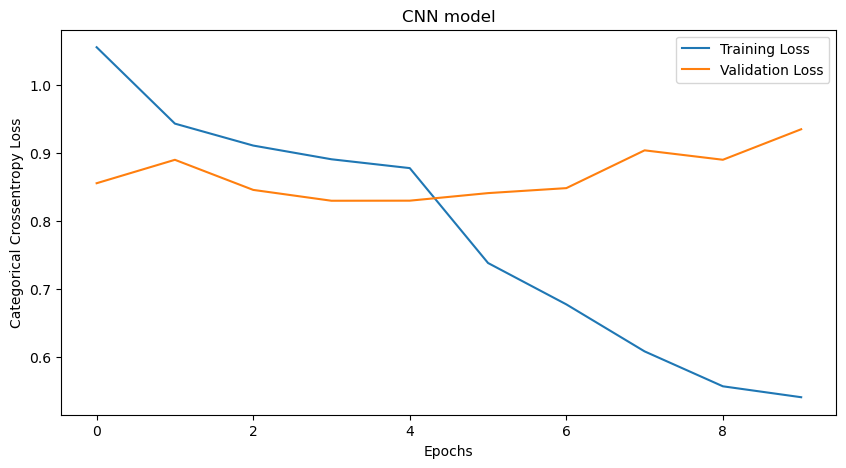

In [25]:
plotLossCurves(history)

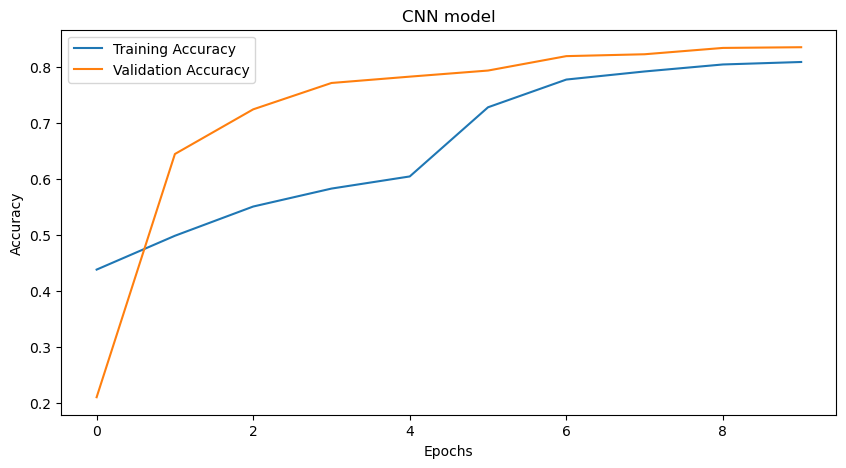

In [26]:
plotAccuracyCurves(history)

150/150 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

        Hate       0.28      0.35      0.31       269
   Offensive       0.91      0.89      0.90      3670
     Neither       0.74      0.76      0.75       834

    accuracy                           0.84      4773
   macro avg       0.64      0.67      0.65      4773
weighted avg       0.85      0.84      0.84      4773

The confusion matrix:
[[  94  148   27]
 [ 211 3262  197]
 [  31  169  634]]


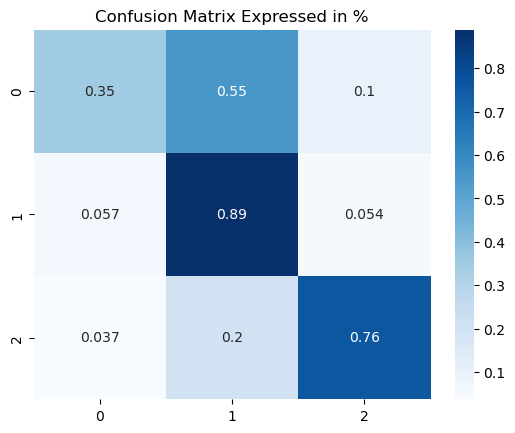

In [27]:
y_pred = model1.predict(X_cv_tk)
predicted_categories = np.argmax(y_pred, axis = 1)
true_categories = np.argmax(y_cv_encoded,axis = 1)

printModelStats(predicted_categories, true_categories)

# grid search (normal model)


# then lstm

## Grid Search

In [26]:
from scikeras.wrappers import KerasClassifier
param_grid = {"num_filters" : [32, 64,128],
              "kernel_size" :[3,5,8]
                }


model = KerasClassifier(build_fn=createCNN1,
                            epochs=10, batch_size=64,
                            verbose=False, kernel_size = 5, num_filters=64)



In [38]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=3, verbose=1)
callbacks_list = [early_stopping]

search = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                              cv=3, verbose=1, n_iter = 5)
search_result = search.fit(X_train_tk, y_train_encoded, validation_data = (X_cv_tk, y_cv_encoded), callbacks=callbacks_list)

c:\miniconda\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Fitting 3 folds for each of 5 candidates, totalling 15 fits
Model: "model_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_42 (InputLayer)       [(None, 127)]             0         
                                                                 
 embedding_41 (Embedding)    (None, 127, 100)          1599200   
                                                                 
 conv1d_41 (Conv1D)          (None, 120, 128)          102528    
                                                                 
 max_pooling1d_41 (MaxPooli  (None, 60, 128)           0         
 ng1D)                                                           
                                                                 
 flatten_41 (Flatten)        (None, 7680)              0         
                                                                 
 dense_82 (Dense)            (None, 10)                76810    

KeyboardInterrupt: 

## Yoon Kim (2014) inspired model 

In Yoon Kim "Convolutional Neural Networks for Sentence Classification", Kim uses a relatively simple CNN for sentence classification and receives great results. Specifically, he uses:
 - embedding dimension of 300 (output_dim)
 - 3 concatenated 1D convolutional layers with kernel sizes of 3,4,5 respectively and ReLu activation
 - 100 filters in each convolutional layer
 - 3 MaxPooling layers
 - A dropout layer of p=0.5
 - L2 regularization with weight of 3

Using these facts, a model was developed and finetuned

Code inspired by:
- https://www.kaggle.com/code/kakiac/deep-learning-4-text-classification-cnn-bi-lstm#CNN-&-Word2Vec-Implementation
- https://www.kaggle.com/code/hamishdickson/cnn-for-sentence-classification-by-yoon-kim#%C2%A0Model-2:-Static-word2vec


In [31]:
kernel_sizes = [3,4,5]
convolutions = []
num_filters = 100
output_dimension = 100

def createCNN2(vocab_size, max_length, output_dimension, num_filters, kernel_sizes):
    
    input = Input(shape=(max_length,), dtype="int32")
    embedding_layer = Embedding(input_dim=vocab_size, output_dim=output_dimension, input_length=max_length)(input)

    convolutions = []
    for size in kernel_sizes:
        conv_layer = Conv1D(filters=num_filters, kernel_size=size, activation="relu",kernel_regularizer=l2(0.8))(embedding_layer) ##, kernel_regularizer=l2(3)
        pooling = MaxPooling1D(pool_size=3)(conv_layer)
        convolutions.append(pooling)
    
    conv_merged = concatenate(convolutions, axis=1)

    dropout = Dropout(0.5)(conv_merged)
    flatten = Flatten()(dropout)
    output = Dense(3, activation="softmax")(flatten)

    model2 = Model(inputs=input, outputs=output)
    optimizer = tensorflow.optimizers.Adam(lr=0.001)
    model2.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    model2.summary()

    return model2


In [32]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=3, verbose=1)
callbacks_list = [early_stopping]

model2 = createCNN2(vocab_size, max_length, output_dimension, num_filters, kernel_sizes)


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 127)]                0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 127, 100)             1902900   ['input_3[0][0]']             
                                                                                                  
 conv1d_2 (Conv1D)           (None, 125, 100)             30100     ['embedding_2[0][0]']         
                                                                                                  
 conv1d_3 (Conv1D)           (None, 124, 100)             40100     ['embedding_2[0][0]']         
                                                                                            

In [33]:
history2 = model2.fit(X_train_tk, y_train_encoded, epochs =10, batch_size=50, validation_data = (X_cv_tk, y_cv_encoded)) # callbacks = callbacks_list


Epoch 1/10
896/896 [==============================] - 81s 89ms/step - loss: 7.6207 - accuracy: 0.5336 - val_loss: 0.7374 - val_accuracy: 0.7374
Epoch 2/10
896/896 [==============================] - 81s 90ms/step - loss: 0.5901 - accuracy: 0.8007 - val_loss: 0.6242 - val_accuracy: 0.7993
Epoch 3/10
896/896 [==============================] - 83s 93ms/step - loss: 0.4609 - accuracy: 0.8595 - val_loss: 0.5125 - val_accuracy: 0.8529
Epoch 4/10
896/896 [==============================] - 82s 92ms/step - loss: 0.3701 - accuracy: 0.8986 - val_loss: 0.5585 - val_accuracy: 0.8250
Epoch 5/10
896/896 [==============================] - 77s 86ms/step - loss: 0.3217 - accuracy: 0.9179 - val_loss: 0.5240 - val_accuracy: 0.8445
Epoch 6/10
896/896 [==============================] - 83s 92ms/step - loss: 0.2882 - accuracy: 0.9291 - val_loss: 0.5580 - val_accuracy: 0.8287
Epoch 7/10
896/896 [==============================] - 84s 93ms/step - loss: 0.2641 - accuracy: 0.9368 - val_loss: 0.5453 - val_accuracy:

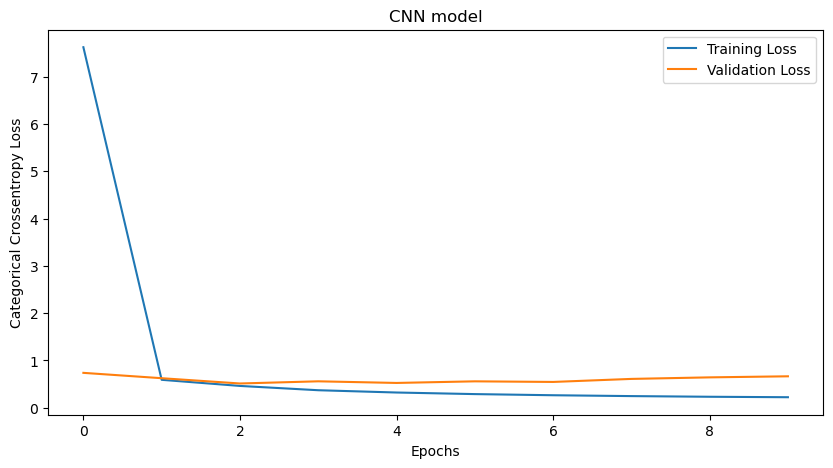

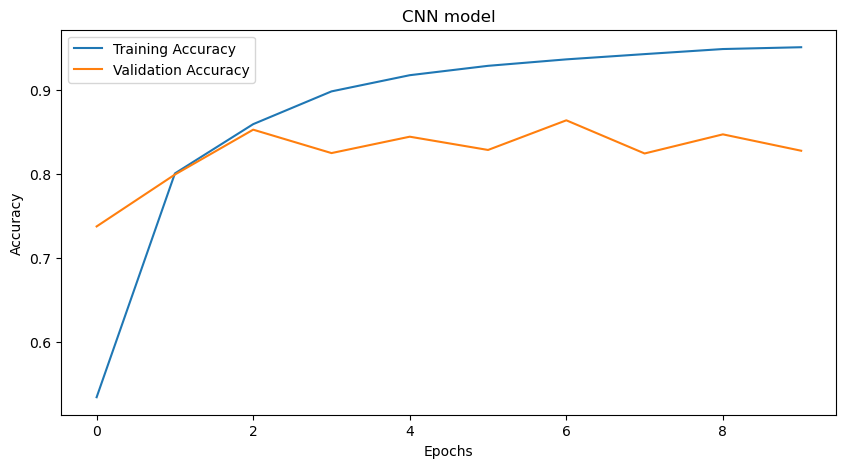

In [34]:
printResults(history2)
plotLossCurves(history2)
plotAccuracyCurves(history2)

68/68 [==============================] - 1s 9ms/step
              precision    recall  f1-score   support

        Hate       0.21      0.34      0.26       131
   Offensive       0.92      0.87      0.89      1662
     Neither       0.79      0.82      0.80       355

    accuracy                           0.83      2148
   macro avg       0.64      0.67      0.65      2148
weighted avg       0.85      0.83      0.84      2148

The confusion matrix:
[[  44   70   17]
 [ 158 1444   60]
 [   9   56  290]]


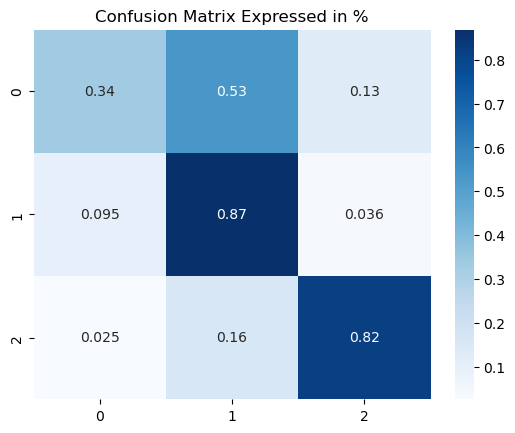

In [35]:
y_pred = model2.predict(X_cv_tk)
predicted_categories = np.argmax(y_pred, axis = 1)
true_categories = np.argmax(y_cv_encoded,axis = 1)


printModelStats(predicted_categories, true_categories)

## CNN with pretrained embedding: Word2Vec

- https://spotintelligence.com/2023/02/15/word2vec-for-text-classification/#Word2Vec_for_text_classification_example

Creating embedding layer

In [31]:
def createW2Vembedding(dimension, sg):
    #Training Word2Vec embedding layer using Skip grams
    sentences = [sentence.split() for sentence in X_train]
    w2v = Word2Vec(sentences, vector_size = dimension, sg=sg)

    #Creating the embedding weight matrix
    embedding_matrix = np.zeros((vocab_size,dimension))

    for word, i in tokenizer.word_index.items():
     if word in w2v.wv:
            embedding_matrix[i] = w2v.wv[word]

    return embedding_matrix


Simple CNN with word2Vec

In [79]:
def createCNNW2V1(num_filters=64,kernel_size=8, output_dimension=100, sg = 1):

    embedding_matrix = createW2Vembedding(output_dimension,sg)

    #Building model

    input = Input(shape=(max_length,), dtype="int32")
    embedding_layer = Embedding(input_dim=vocab_size, output_dim=output_dimension, input_length=max_length, weights = [embedding_matrix])(input)
    
    convolution = Conv1D(filters = num_filters, kernel_size = kernel_size, activation = 'relu')(embedding_layer)
    pooling = MaxPooling1D(pool_size=2)(convolution) #pooling to downsample feature extraction
    flatten = Flatten()(pooling)
    dense_1 = Dense(10, activation ='relu', kernel_regularizer=l2(0.01)) (flatten)
    dropout = Dropout(0.5)(dense_1)
    output = Dense(3, activation = "softmax") (dropout)

    model1 = Model(inputs=input, outputs=output)
    optimizer = tensorflow.optimizers.Adam(lr=0.0001)
    model1.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    model1.summary()

    return model1


early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=3, verbose=1)
callbacks_list = [early_stopping]

In [80]:
num_filters = 64
output_dimension = 100
kernel_size = 5
sg = 1

modelW2V1 = createCNNW2V1(num_filters,kernel_size, output_dimension, sg)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 127)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 127, 100)          1599200   
                                                                 
 conv1d_5 (Conv1D)           (None, 123, 64)           32064     
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 61, 64)            0         
 g1D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 3904)              0         
                                                                 
 dense_5 (Dense)             (None, 10)                39050     
                                                           

In [81]:
history = modelW2V1.fit(X_train_tk, y_train_encoded, epochs =10, batch_size=64, validation_data = (X_cv_tk, y_cv_encoded),callbacks=callbacks_list ) #, callbacks=callbacks_list


Epoch 1/10
519/519 [==============================] - 22s 40ms/step - loss: 0.7197 - accuracy: 0.6824 - val_loss: 0.5227 - val_accuracy: 0.8466
Epoch 2/10
519/519 [==============================] - 23s 44ms/step - loss: 0.4228 - accuracy: 0.8294 - val_loss: 0.4851 - val_accuracy: 0.8584
Epoch 3/10
519/519 [==============================] - 25s 48ms/step - loss: 0.3505 - accuracy: 0.8568 - val_loss: 0.5016 - val_accuracy: 0.8466
Epoch 4/10
519/519 [==============================] - 28s 54ms/step - loss: 0.3215 - accuracy: 0.8663 - val_loss: 0.5377 - val_accuracy: 0.8519
Epoch 5/10
519/519 [==============================] - 24s 47ms/step - loss: 0.3056 - accuracy: 0.8653 - val_loss: 0.5414 - val_accuracy: 0.8563
Epoch 5: early stopping


In [83]:
loss,acc = modelW2V1.evaluate(X_cv_tk, y_cv_encoded)


150/150 [==============================] - 1s 4ms/step - loss: 0.5414 - accuracy: 0.8563


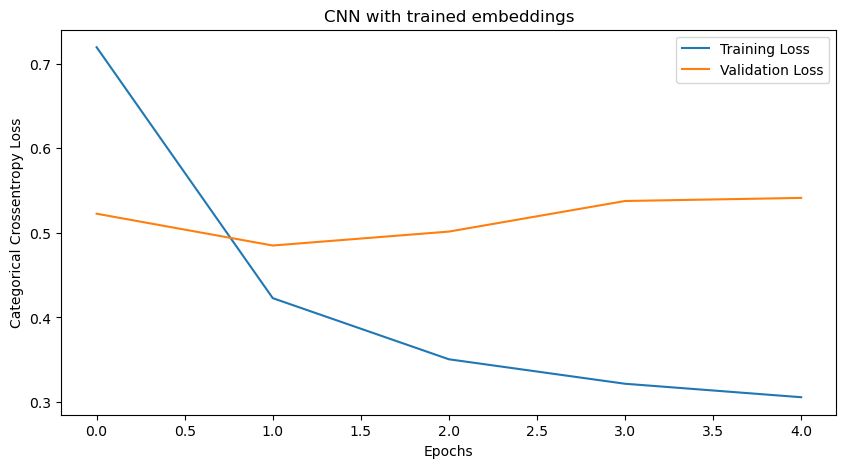

In [84]:
plotLossCurves(history)

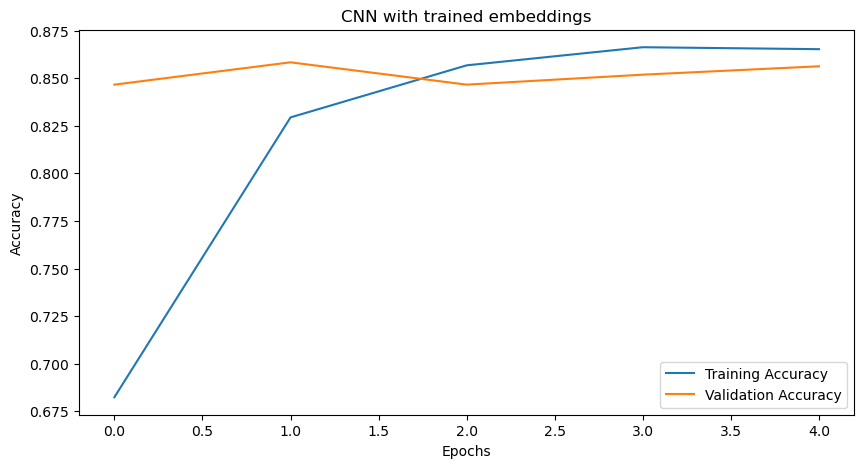

In [85]:
plotAccuracyCurves(history)

150/150 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

        Hate       0.32      0.23      0.27       269
   Offensive       0.89      0.94      0.91      3670
     Neither       0.81      0.69      0.75       834

    accuracy                           0.86      4773
   macro avg       0.67      0.62      0.64      4773
weighted avg       0.85      0.86      0.85      4773

The confusion matrix:
[[  63  180   26]
 [ 119 3445  106]
 [  16  239  579]]


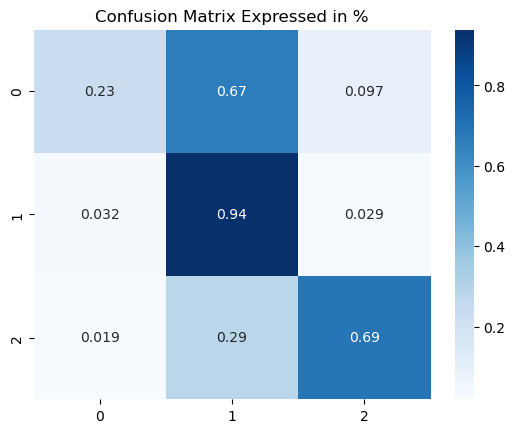

In [86]:
y_pred = modelW2V1.predict(X_cv_tk)
predicted_categories = np.argmax(y_pred, axis = 1)
true_categories = np.argmax(y_cv_encoded,axis = 1)

printModelStats(predicted_categories, true_categories)

Yoon Kim CNN with word2Vec

In [107]:
kernel_sizes = [3,4,5]
convolutions = []
num_filters = 100
output_dimension = 100

def createCNN2W2V(vocab_size, max_length, output_dimension, num_filters, kernel_sizes, sg):
    embedding_matrix = createW2Vembedding(output_dimension,sg)

    input = Input(shape=(max_length,), dtype="int32")
    embedding_layer = Embedding(input_dim=vocab_size, output_dim=output_dimension, weights=[embedding_matrix], input_length=max_length)(input)

    convolutions = []
    for size in kernel_sizes:
        conv_layer = Conv1D(filters=num_filters, kernel_size=size, activation="relu",kernel_regularizer=l2(3))(embedding_layer) ##, kernel_regularizer=l2(3)
        pooling = MaxPooling1D(pool_size=3)(conv_layer)
        convolutions.append(pooling)
    
    conv_merged = concatenate(convolutions, axis=1)

    dropout = Dropout(0.5)(conv_merged)
    flatten = Flatten()(dropout)
    output = Dense(3, activation="softmax")(flatten)

    model2 = Model(inputs=input, outputs=output)
    optimizer = tensorflow.optimizers.Adam(lr=0.001)#try making smaller
    model2.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    model2.summary()

    return model2

In [108]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=3, verbose=1)
callbacks_list = [early_stopping]

modelW2V2 = createCNN2W2V(vocab_size, max_length, output_dimension, num_filters, kernel_sizes, sg=1)


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 127)]                0         []                            
                                                                                                  
 embedding_6 (Embedding)     (None, 127, 100)             1599200   ['input_7[0][0]']             
                                                                                                  
 conv1d_10 (Conv1D)          (None, 125, 100)             30100     ['embedding_6[0][0]']         
                                                                                                  
 conv1d_11 (Conv1D)          (None, 124, 100)             40100     ['embedding_6[0][0]']         
                                                                                            

In [109]:
history2 = modelW2V2.fit(X_train_tk, y_train_encoded, epochs =10, batch_size=64, validation_data = (X_cv_tk, y_cv_encoded))


Epoch 1/10
519/519 [==============================] - 55s 105ms/step - loss: 44.2804 - accuracy: 0.5696 - val_loss: 0.7528 - val_accuracy: 0.7873
Epoch 2/10
519/519 [==============================] - 55s 106ms/step - loss: 0.6672 - accuracy: 0.7901 - val_loss: 0.6960 - val_accuracy: 0.7928
Epoch 3/10
519/519 [==============================] - 56s 108ms/step - loss: 0.5611 - accuracy: 0.8438 - val_loss: 0.6860 - val_accuracy: 0.7846
Epoch 4/10
519/519 [==============================] - 55s 106ms/step - loss: 0.4739 - accuracy: 0.8898 - val_loss: 0.6860 - val_accuracy: 0.7978
Epoch 5/10
519/519 [==============================] - 56s 108ms/step - loss: 0.4155 - accuracy: 0.9164 - val_loss: 0.6741 - val_accuracy: 0.8064
Epoch 6/10
519/519 [==============================] - 1652s 3s/step - loss: 0.3780 - accuracy: 0.9298 - val_loss: 0.6276 - val_accuracy: 0.8028
Epoch 7/10
519/519 [==============================] - 70s 136ms/step - loss: 0.3669 - accuracy: 0.9396 - val_loss: 0.5768 - val_ac

In [110]:
printResults(history2)


,loss,accuracy,val_loss,val_accuracy
0,44.280437,0.569608,0.752837,0.787345
1,0.667175,0.790062,0.696045,0.792793
2,0.561123,0.843790,0.686039,0.784622
3,0.473936,0.889803,0.685987,0.797821
4,0.415479,0.916411,0.674133,0.806411
5,0.378020,0.929850,0.627604,0.802849
6,0.366939,0.939643,0.576845,0.856903
7,0.339050,0.946755,0.754471,0.817934
8,0.337539,0.948653,0.621527,0.858370
9,0.327445,0.952932,0.648503,0.866331


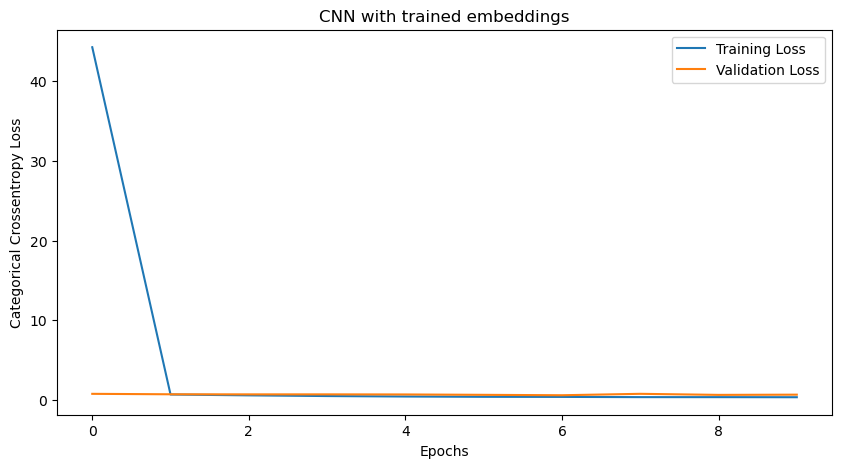

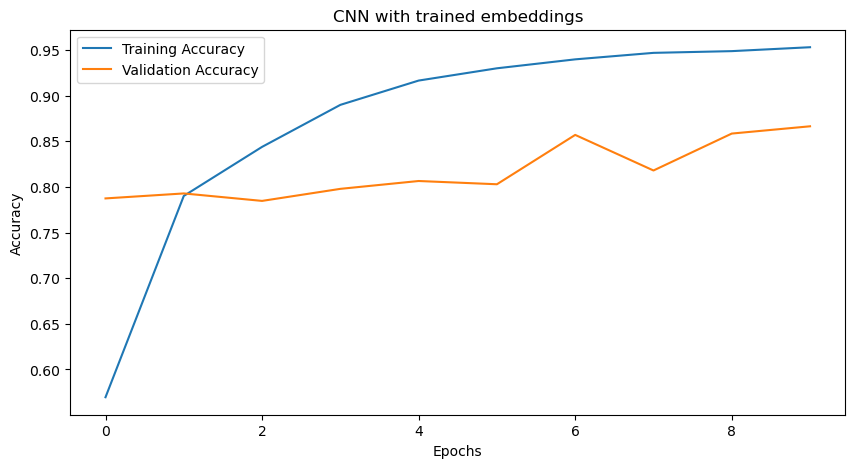

In [111]:
plotLossCurves(history2)
plotAccuracyCurves(history2)

150/150 [==============================] - 4s 30ms/step
              precision    recall  f1-score   support

        Hate       0.25      0.31      0.28       269
   Offensive       0.93      0.90      0.91      3670
     Neither       0.77      0.80      0.79       834

    accuracy                           0.85      4773
   macro avg       0.65      0.67      0.66      4773
weighted avg       0.86      0.85      0.86      4773

The confusion matrix:
[[  83  152   34]
 [ 198 3312  160]
 [  51  116  667]]


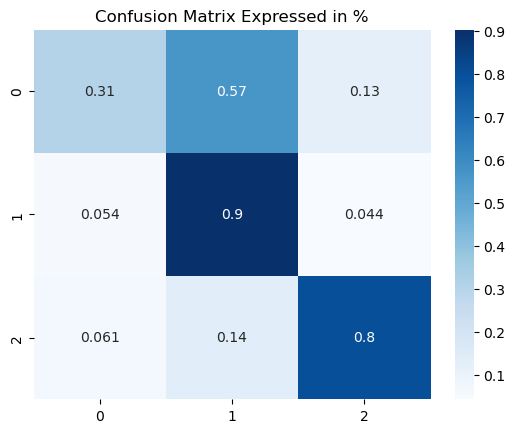

In [112]:
y_pred = model2.predict(X_cv_tk)
predicted_categories = np.argmax(y_pred, axis = 1)
true_categories = np.argmax(y_cv_encoded,axis = 1)


printModelStats(predicted_categories, true_categories)

## CNN with pretrained embedding: glove

Opening glove file

In [70]:
from gensim.scripts.glove2word2vec import glove2word2vec
import gensim.downloader as api

In [71]:
glove_model = api.load("glove-wiki-gigaword-100")

[==================================================] 100.0% 128.1/128.1MB downloaded


Create embedding matrix

In [89]:
def createGloveEmbedding(glove_model, dimension):
    embedding_matrix = np.zeros((vocab_size, dimension))

    for word, i in tokenizer.word_index.items():
     
     #trying to find word in glove model
     if word in glove_model:
            embedding_matrix[i] = glove_model[word]

    return embedding_matrix

    

Creating glove embedding

Simple 1D CNN with glove embedding (dimension = 100)

In [90]:
def createCNNGlove1(num_filters=64,kernel_size=8, output_dimension=100):

    embedding_matrix = createGloveEmbedding(glove_model,output_dimension)

    #Building model

    input = Input(shape=(max_length,), dtype="int32")
    embedding_layer = Embedding(input_dim=vocab_size, output_dim=output_dimension, input_length=max_length, weights = [embedding_matrix])(input)
    
    convolution = Conv1D(filters = num_filters, kernel_size = kernel_size, activation = 'relu')(embedding_layer)
    pooling = MaxPooling1D(pool_size=2)(convolution) #pooling to downsample feature extraction
    flatten = Flatten()(pooling)
    dense_1 = Dense(10, activation ='relu', kernel_regularizer=l2(0.01)) (flatten)
    dropout = Dropout(0.5)(dense_1)
    output = Dense(3, activation = "softmax") (dropout)

    model1 = Model(inputs=input, outputs=output)
    optimizer = tensorflow.optimizers.Adam(lr=0.0001)
    model1.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    model1.summary()

    return model1


early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=3, verbose=1)
callbacks_list = [early_stopping]

In [91]:
num_filters = 64
output_dimension = 100
kernel_size = 5


modelGlove1 = createCNNGlove1(num_filters,kernel_size, output_dimension)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 127)]             0         
                                                                 
 embedding_4 (Embedding)     (None, 127, 100)          1599200   
                                                                 
 conv1d_6 (Conv1D)           (None, 123, 64)           32064     
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 61, 64)            0         
 g1D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 3904)              0         
                                                                 
 dense_7 (Dense)             (None, 10)                39050     
                                                           

In [92]:
history = modelGlove1.fit(X_train_tk, y_train_encoded, epochs =10, batch_size=64, validation_data = (X_cv_tk, y_cv_encoded),callbacks=callbacks_list ) #, callbacks=callbacks_list


Epoch 1/10
519/519 [==============================] - 31s 53ms/step - loss: 0.6460 - accuracy: 0.7302 - val_loss: 0.4571 - val_accuracy: 0.8466
Epoch 2/10
519/519 [==============================] - 28s 54ms/step - loss: 0.3217 - accuracy: 0.8776 - val_loss: 0.4351 - val_accuracy: 0.8741
Epoch 3/10
519/519 [==============================] - 27s 52ms/step - loss: 0.2441 - accuracy: 0.8992 - val_loss: 0.4826 - val_accuracy: 0.8586
Epoch 4/10
519/519 [==============================] - 27s 53ms/step - loss: 0.2069 - accuracy: 0.9079 - val_loss: 0.5173 - val_accuracy: 0.8676
Epoch 5/10
519/519 [==============================] - 27s 52ms/step - loss: 0.1839 - accuracy: 0.9129 - val_loss: 0.4988 - val_accuracy: 0.8712
Epoch 5: early stopping


In [93]:
loss,acc = modelGlove1.evaluate(X_cv_tk, y_cv_encoded)

150/150 [==============================] - 1s 9ms/step - loss: 0.4988 - accuracy: 0.8712


In [94]:
printResults(history)

,loss,accuracy,val_loss,val_accuracy
0,0.646014,0.730248,0.457080,0.846637
1,0.321676,0.877629,0.435093,0.874083
2,0.244070,0.899235,0.482608,0.858580
3,0.206910,0.907913,0.517253,0.867589
4,0.183866,0.912915,0.498764,0.871150


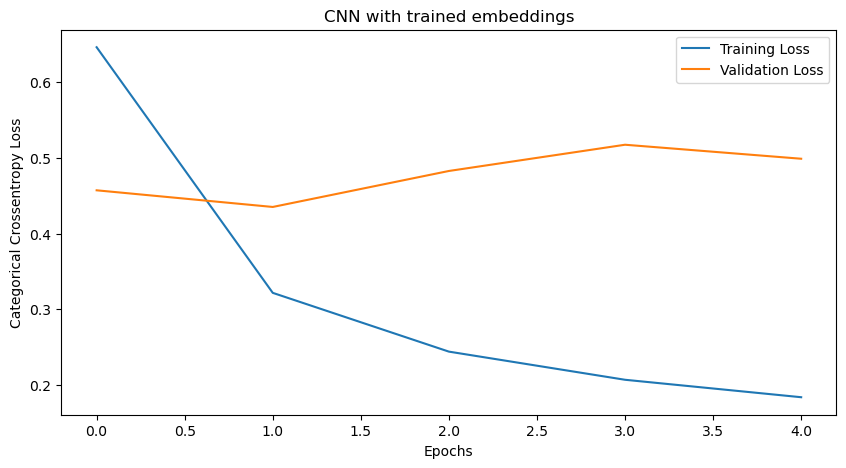

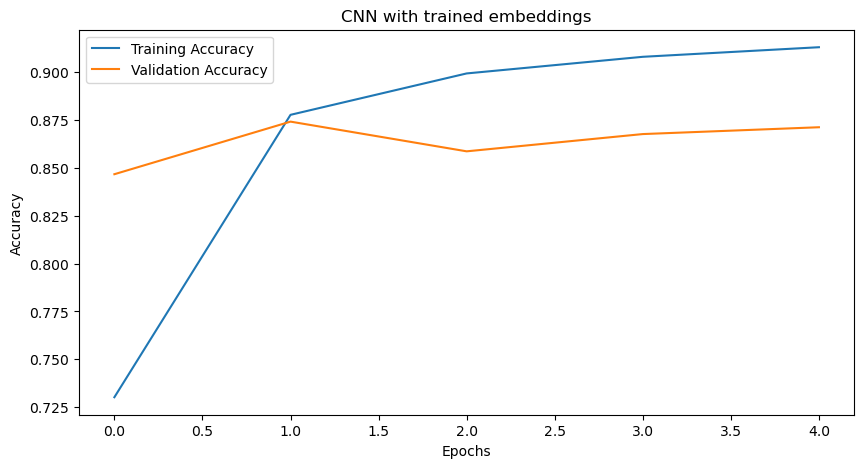

In [95]:
plotLossCurves(history)
plotAccuracyCurves(history)

150/150 [==============================] - 2s 9ms/step
              precision    recall  f1-score   support

        Hate       0.33      0.23      0.27       269
   Offensive       0.92      0.93      0.93      3670
     Neither       0.77      0.82      0.80       834

    accuracy                           0.87      4773
   macro avg       0.67      0.66      0.66      4773
weighted avg       0.86      0.87      0.87      4773

The confusion matrix:
[[  61  156   52]
 [ 110 3412  148]
 [  16  133  685]]


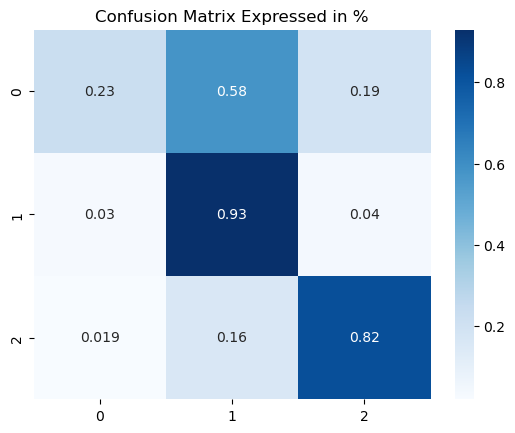

In [97]:
y_pred = modelGlove1.predict(X_cv_tk)
predicted_categories = np.argmax(y_pred, axis = 1)
true_categories = np.argmax(y_cv_encoded,axis = 1)

printModelStats(predicted_categories, true_categories)

Yoon Kim model with Glove embedding

In [100]:
kernel_sizes = [3,4,5]
convolutions = []
num_filters = 100
output_dimension = 100

def createCNNGlove2(vocab_size, max_length, output_dimension, num_filters, kernel_sizes):
    embedding_matrix = createGloveEmbedding(glove_model,output_dimension)

    input = Input(shape=(max_length,), dtype="int32")
    embedding_layer = Embedding(input_dim=vocab_size, output_dim=output_dimension, weights=[embedding_matrix], input_length=max_length)(input)

    convolutions = []
    for size in kernel_sizes:
        conv_layer = Conv1D(filters=num_filters, kernel_size=size, activation="relu",kernel_regularizer=l2(3))(embedding_layer) ##, kernel_regularizer=l2(3)
        pooling = MaxPooling1D(pool_size=3)(conv_layer)
        convolutions.append(pooling)
    
    conv_merged = concatenate(convolutions, axis=1)

    dropout = Dropout(0.5)(conv_merged)
    flatten = Flatten()(dropout)
    output = Dense(3, activation="softmax")(flatten)

    model2 = Model(inputs=input, outputs=output)
    optimizer = tensorflow.optimizers.Adam(lr=0.001)#try making smaller
    model2.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    model2.summary()

    return model2

In [101]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=3, verbose=1)
callbacks_list = [early_stopping]

modelGlove2 = createCNNGlove2(vocab_size, max_length, output_dimension, num_filters, kernel_sizes)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 127)]                0         []                            
                                                                                                  
 embedding_5 (Embedding)     (None, 127, 100)             1599200   ['input_6[0][0]']             
                                                                                                  
 conv1d_7 (Conv1D)           (None, 125, 100)             30100     ['embedding_5[0][0]']         
                                                                                                  
 conv1d_8 (Conv1D)           (None, 124, 100)             40100     ['embedding_5[0][0]']         
                                                                                            

In [103]:
history2 = modelGlove2.fit(X_train_tk, y_train_encoded, epochs =10, batch_size=64, validation_data = (X_cv_tk, y_cv_encoded))


Epoch 1/10


519/519 [==============================] - 59s 112ms/step - loss: 44.4244 - accuracy: 0.5231 - val_loss: 0.9340 - val_accuracy: 0.7234
Epoch 2/10
519/519 [==============================] - 54s 104ms/step - loss: 0.7847 - accuracy: 0.7105 - val_loss: 0.7939 - val_accuracy: 0.7503
Epoch 3/10
519/519 [==============================] - 57s 109ms/step - loss: 0.6812 - accuracy: 0.7991 - val_loss: 0.7847 - val_accuracy: 0.7775
Epoch 4/10
519/519 [==============================] - 59s 113ms/step - loss: 0.6158 - accuracy: 0.8622 - val_loss: 0.7458 - val_accuracy: 0.8186
Epoch 5/10
519/519 [==============================] - 61s 118ms/step - loss: 0.5541 - accuracy: 0.8955 - val_loss: 0.7166 - val_accuracy: 0.8144
Epoch 6/10
519/519 [==============================] - 63s 122ms/step - loss: 0.5061 - accuracy: 0.9165 - val_loss: 0.6611 - val_accuracy: 0.8609
Epoch 7/10
519/519 [==============================] - 62s 119ms/step - loss: 0.4977 - accuracy: 0.9257 - val_loss: 0.6255 - val_accuracy: 0.

In [104]:
printResults(history2)

,loss,accuracy,val_loss,val_accuracy
0,44.424381,0.523082,0.934005,0.723444
1,0.784710,0.710450,0.793938,0.750262
2,0.681154,0.799102,0.784665,0.777498
3,0.615801,0.862171,0.745760,0.818563
4,0.554114,0.895498,0.716596,0.814373
5,0.506086,0.916471,0.661107,0.860884
6,0.497727,0.925661,0.625543,0.863189
7,0.465023,0.936268,0.665856,0.852504
8,0.455403,0.941090,0.686005,0.854389
9,0.441849,0.947056,0.658302,0.866960


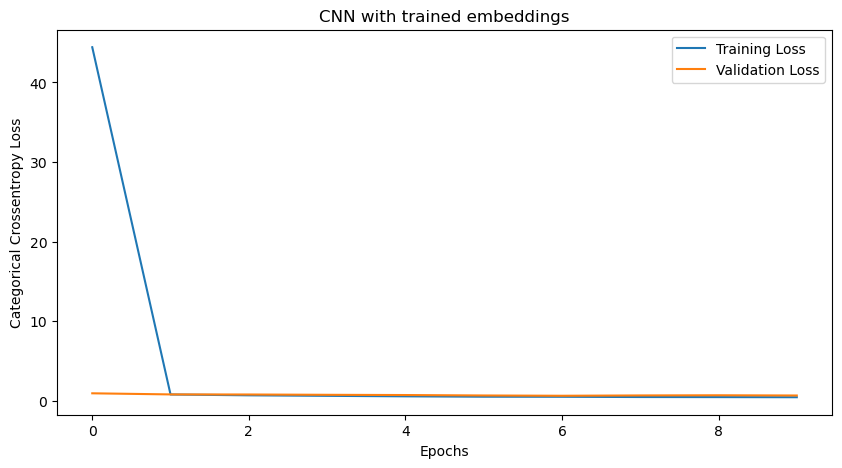

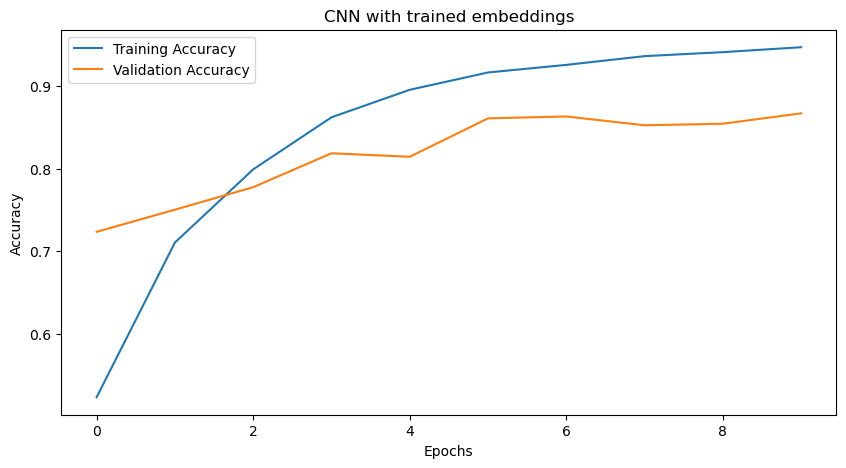

In [105]:
plotLossCurves(history2)
plotAccuracyCurves(history2)

150/150 [==============================] - 1s 9ms/step
              precision    recall  f1-score   support

        Hate       0.32      0.41      0.36       269
   Offensive       0.95      0.90      0.92      3670
     Neither       0.77      0.86      0.81       834

    accuracy                           0.87      4773
   macro avg       0.68      0.72      0.70      4773
weighted avg       0.88      0.87      0.87      4773

The confusion matrix:
[[ 111  113   45]
 [ 193 3310  167]
 [  46   71  717]]


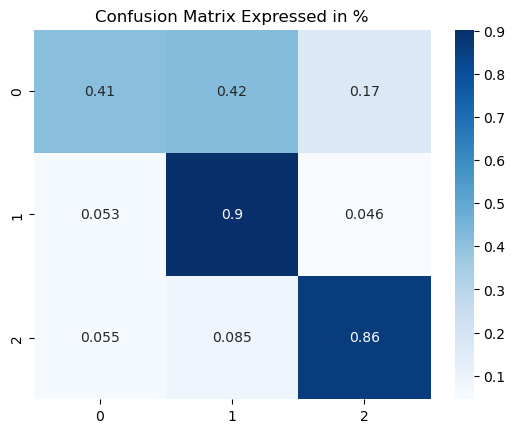

In [106]:
y_pred = modelGlove2.predict(X_cv_tk)
predicted_categories = np.argmax(y_pred, axis = 1)
true_categories = np.argmax(y_cv_encoded,axis = 1)


printModelStats(predicted_categories, true_categories)

## Parameter search